## objectives of preprocessing
    
- data should be 2D array
- input data has to be numbers
- no nan or inf
- coloum are scaled to similar ranges (mean=0, variance=1)
- coloums should not be coliner (cx1!=k*cx2)
- rows should not be causally dependent
- data should be 100 times larger then the number of coloums 

In [1]:
!pwd

/home/547/sg4953/uncoverml/notebook


In [3]:
/home/547/sg4953/uncoverml/notebook/preprocessing.ipynb

'Bayesian Search.ipynb'		 'Testing lightgbm.ipynb'
'Feature Ranking 1.ipynb'	  Tmp.ipynb
'Feature Ranking 2.ipynb'	  backup
'Feature Ranking 3.ipynb'	  base.png
'Feature Ranking Backup.ipynb'	  max_abs_df.pkl
'Fix Feature Ele Results.ipynb'   preprocessing.ipynb
'Grid Search.ipynb'		  xgboost.ipynb


## import python libraries 

In [3]:
import os
import pathlib
from pprint import pprint
from pathlib import Path
import csv

In [4]:
import ray
import rasterio
import fiona
import pandas as pd
import xgboost as xgb
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

import matplotlib.pyplot as plt

In [5]:
%load_ext memory_profiler

## define input datasets

- features 
- targets 
- out of sample 
- area of interest

In [5]:
%%time

feature_file_paths = [
Path('/g/data/ge3/sheece/LOC_distance_to_coast.tif'),
Path('/g/data/ge3/sheece/mrvbf_9.tif'),
Path('/g/data/ge3/sheece/relief_mrvbf_3s_mosaic.tif'),
Path('/g/data/ge3/sheece/relief_elev_focalrange1000m_3s.tif'),
Path('/g/data/ge3/sheece/relief_elev_focalrange300m_3s.tif'),
Path('/g/data/ge3/sheece/saga_wetSM_85.tif'),
Path('/g/data/ge3/sheece/tpi_300.tif'),
Path('/g/data/ge3/sheece/slope_fill2.tif'),
Path('/g/data/ge3/sheece/dem_fill.tif'),
Path('/g/data/ge3/sheece/3dem_mag2.tif'),
Path('/g/data/ge3/sheece/3dem_mag1_fin.tif'),
Path('/g/data/ge3/sheece/3dem_mag0.fin.tif'),
Path('/g/data/ge3/sheece/relief_roughness.tif'),
Path('/g/data/ge3/sheece/LATITUDE_GRID1_clip.tif'),
Path('/g/data/ge3/sheece/LATITUDE_GRID1_clip.tif'),
Path('/g/data/ge3/sheece/Dose_2016.tif'),
Path('/g/data/ge3/sheece/Potassium_2016.tif'),
Path('/g/data/ge3/sheece/Thorium_2016.tif'),
Path('/g/data/ge3/sheece/Rad2016U_Th.tif'),
Path('/g/data/ge3/sheece/Rad2016K_Th.tif'),
Path('/g/data/ge3/sheece/national_Wii_RF_multirandomforest_prediction.tif'),
Path('/g/data/ge3/sheece/si_geol1.tif'),
Path('/g/data/ge3/sheece/ceno_euc_aust1.tif'),
Path('/g/data/ge3/sheece/Grav_lane_clip.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg_BLUE+SWIR2.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-CLAY-PC2.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-RED.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-GREEN.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-l8-all-85m-avg-BLUE.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-l8-all-85m-avg-NIR.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-SWIR1.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-SWIR2.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/s2-dpca-85m.tif'),
Path('/g/data/ge3/sheece/water-85m.tif'),
Path('/g/data/ge3/sheece/clim_EPA_albers.tif'),
Path('/g/data/ge3/sheece/Clim_Prescott_LindaGregory.tif'),
Path('/g/data/ge3/sheece/clim_PTA_albers.tif'),
Path('/g/data/ge3/sheece/clim_WDA_albers.tif'),
Path('/g/data/ge3/sheece/clim_RSM_albers.tif'),
Path('/g/data/ge3/sheece/LONGITUDE_GRID1_clip.tif')
]

#target dataset small
# /g/data/ge3/sheece/0_50cm_2021_albers_C_sm_T_resampled_small.shp
#target dataset complete
# /g/data/ge3/sheece/0_50cm_2021_albers_C_sm_T_resampled.shp
target_file_path = Path("/g/data/ge3/sheece/0_50cm_2021_albers_C_sm_T_resampled.shp")

# define a shape for area of intrest
area_of_interest_file_path = None

#OOS
# /g/data/ge3/sheece/0_50cm_2021_albers_C_oos.shp
out_of_sample_file_path = Path("/g/data/ge3/sheece/0_50cm_2021_albers_C_oos.shp")

root = Path('/g/data/ge3/sheece')

CPU times: user 231 µs, sys: 53 µs, total: 284 µs
Wall time: 288 µs


In [6]:
# remove duplicates

temp_feature_file_paths = feature_file_paths.copy()
unique_values = list(set(temp_feature_file_paths))
for unique_value in unique_values:
    temp_feature_file_paths.remove(unique_value)

print("Following are duplicates:")
print(temp_feature_file_paths)

feature_file_paths = list(set(feature_file_paths))

Following are duplicates:
[PosixPath('/g/data/ge3/sheece/LATITUDE_GRID1_clip.tif'), PosixPath('/g/data/ge3/sheece/be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata.tif')]


In [7]:
# check if file exist
import os.path

for feature_file_path in feature_file_paths:
    if not os.path.isfile(feature_file_path):
        feature_file_paths.remove(feature_file_path)
        print ("File not exist",feature_file_path)
    
        


In [8]:
if not os.path.isdir(root/"old"):
    os.mkdir(root/"old") 

## Standardising Datasets

In [9]:
# check if all datasets have only one band
import shutil

for feature_file_path in feature_file_paths:
    with rasterio.open(feature_file_path) as dataset:
        if len(dataset.indexes) >1: 
            print("Processing dataset: ",feature_file_path)
            for band in dataset.indexes:
                path_to_new_dataset = root/ str(feature_file_path.stem +"_"+str(band)+".tif")
                print("Reading data from band: ",band)
                new_dataset = rasterio.open(
                    path_to_new_dataset,
                     'w',
                     driver='GTiff',
                     height=dataset.shape[0],
                     width=dataset.shape[1],
                     count=1,
                     dtype=dataset.meta['dtype'],
                     crs=dataset.crs,
                     transform=dataset.transform
                )
                
                new_dataset.write(dataset.read(band),1)
                new_dataset.close()
                print("New dataset added:",path_to_new_dataset)
                feature_file_paths.append(path_to_new_dataset)
    
            print("Removing multiband dataset:",feature_file_path)
            feature_file_paths.remove(feature_file_path)

Processing dataset:  /g/data/ge3/sheece/s2-dpca-85m.tif
Reading data from band:  1
New dataset added: /g/data/ge3/sheece/s2-dpca-85m_1.tif
Reading data from band:  2
New dataset added: /g/data/ge3/sheece/s2-dpca-85m_2.tif
Reading data from band:  3
New dataset added: /g/data/ge3/sheece/s2-dpca-85m_3.tif
Removing multiband dataset: /g/data/ge3/sheece/s2-dpca-85m.tif
Processing dataset:  /g/data/ge3/sheece/water-85m.tif
Reading data from band:  1
New dataset added: /g/data/ge3/sheece/water-85m_1.tif
Reading data from band:  2
New dataset added: /g/data/ge3/sheece/water-85m_2.tif
Reading data from band:  3
New dataset added: /g/data/ge3/sheece/water-85m_3.tif
Removing multiband dataset: /g/data/ge3/sheece/water-85m.tif


In [10]:
# check if all datasets are in same projections 
import shutil
from rasterio.warp import calculate_default_transform, reproject, Resampling

# check projection 
crs_epsg3577 = rasterio.crs.CRS.from_string('EPSG:3577')

for feature_file_path in feature_file_paths:
    with rasterio.open(feature_file_path) as src:
        if crs_epsg3577 != src.crs:
            print("Converting dataset: "+str(feature_file_path))
            transform, width, height = calculate_default_transform(
                src.crs, 
                crs_epsg3577, 
                src.width, 
                src.height, 
                *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({'crs': crs_epsg3577,'transform': transform, 'width': width,'height': height})

            new_feature_file_path = feature_file_path.parent /str(feature_file_path.stem+"_reprojected.tif")
            with rasterio.open(new_feature_file_path, 'w', **kwargs) as dst:
                reproject(
                    source=rasterio.band(src, 1),
                    destination=rasterio.band(dst, 1),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=crs_epsg3577,
                    resampling=Resampling.nearest)
            feature_file_paths.remove(feature_file_path)
            feature_file_paths.append(new_feature_file_path)
            print("Dataset: ",feature_file_path, " has been reprojected and saved as: ",new_feature_file_path)


Converting dataset: /g/data/ge3/sheece/saga_wetSM_85.tif
Dataset:  /g/data/ge3/sheece/saga_wetSM_85.tif  has been reprojected and saved as:  /g/data/ge3/sheece/saga_wetSM_85_reprojected.tif


In [11]:
# apply crop on target and feature datasets according to area of intrest 
import fiona
import rasterio
from rasterio.mask import mask

if area_of_interest_file_path is not None:
    with fiona.open(area_of_interest_file_path) as shapefile:
        geoms = [feature["geometry"] for feature in shapefile]

    for feature_file_path in feature_file_paths:
        if "cropped" not in feature_file_path.name:
            print("Cropping : "+feature_file_path.stem)
            # load the raster, mask it by the polygon and crop it
            with rasterio.open(feature_file_path) as src:
                out_image, out_transform = mask(src, geoms, crop=True)
            out_meta = src.meta.copy()

            # save the resulting raster  
            out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
            })   

            with rasterio.open(root/(feature_file_path.stem+'_cropped.tif'), "w", **out_meta) as dest:
                dest.write(out_image)

            shutil.move(feature_file_path, root/("old/"+feature_file_path.name))

In [12]:
# apply crop vector files(.shp)
import subprocess

if area_of_interest_file_path is not None:
    if "cropped" not in target_file_path.name:
        print("Cropping: "+target_file_path.name)
        clipped_file = root/(target_file_path.stem+'_cropped.shp')
        callstr = ['ogr2ogr',
                   '-clipsrc',
                   area_of_interest_file_path,
                   clipped_file,
                   target_file_path] 
        proc = subprocess.Popen(callstr, stdout=subprocess.PIPE,stderr=subprocess.PIPE)
        stdout,stderr=proc.communicate()

        shutil.move(target_file_path, root/("old/"+target_file_path.name))

In [13]:
# create iterators ( C++ pointers) to inputs feature dataset and target dataset
datasets = []
for feature_file_path in feature_file_paths: 
    datasets.append(rasterio.open(feature_file_path))

target_handle = fiona.open(target_file_path)

In [14]:
%%time
%%memit

head_row = ['target']
for feature_file_path in feature_file_paths:
    head_row.append(feature_file_path.stem)
head_row.append("x")
head_row.append("y")
    
csv_rowlist = [head_row]
with open('../data/input_dataset.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # iterate through list of targets
    for target in target_handle:
        value = target["properties"]["con"]
        x, y = target["geometry"]["coordinates"]
        new_row = [value]
        
        # iterate through list of features
        for dataset in datasets:
            new_row.append(next(dataset.sample([(x, y)]))[0])
        new_row.append(x)
        new_row.append(y)
        
        csv_rowlist.append(new_row)

        if len(csv_rowlist)%1000==0:
            writer.writerows(csv_rowlist)
            csv_rowlist = []

peak memory: 20508.67 MiB, increment: 12229.63 MiB
CPU times: user 21min 13s, sys: 1min 50s, total: 23min 3s
Wall time: 30min 58s


In [15]:
!pwd

/home/547/sg4953/uncoverml/notebook


In [16]:
target_handle.close()
for dataset in datasets: 
    dataset.close()

## Cleaning dataset

In [17]:
%%time
input_file = '../data/input_dataset.csv'
print("input_file: ",input_file)
df = pd.read_csv(input_file)
input_shape = df.shape
df = df.drop(["x","y"],axis=1).astype('float32') 
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]

df.to_csv("../data/formated_dataset.csv",index=None,header=df.columns.values)
output_shape = df.shape
print("Number of rows removed: ",input_shape[0]-output_shape[0])


input_file:  ../data/input_dataset.csv
Number of rows removed:  1682
CPU times: user 16.6 s, sys: 640 ms, total: 17.2 s
Wall time: 18.1 s


## Exploring Normalization
- Rescaling (min-max normalization)
- Standardization (Z-scale normalization)



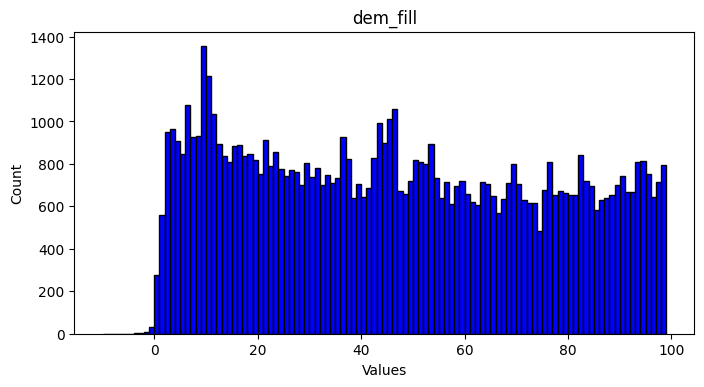

In [270]:
## density plots for input features
dataset_id = 23
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
col_name = df.columns.values[dataset_id]
plt.xlabel('Values')
plt.ylabel('Count')
plt.title(col_name)
_ = plt.hist(df[col_name], color = 'blue', edgecolor = 'black', bins = np.arange(-10,100,1),label=col_name )

In [8]:
scaler = preprocessing.StandardScaler().fit(df)
scaled_df = scaler.transform(df)

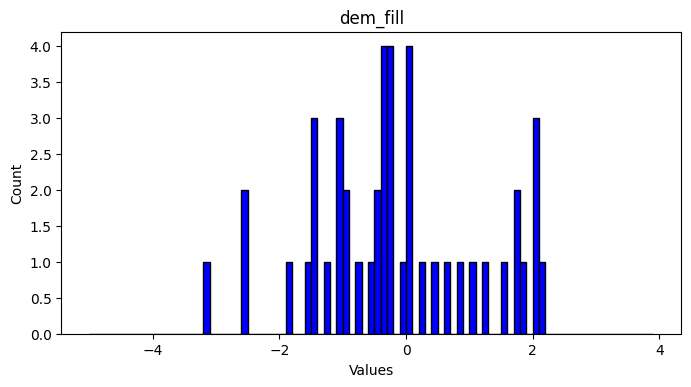

In [271]:


plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
col_name = df.columns.values[dataset_id]
plt.xlabel('Values')
plt.ylabel('Count')
plt.title(col_name)
_ = plt.hist(scaled_df[dataset_id], color = 'blue', edgecolor = 'black', bins = np.arange(-5,4,0.1),label=col_name )

In [230]:
scaler = preprocessing.QuantileTransformer().fit(df)
quantile_df = scaler.transform(df)

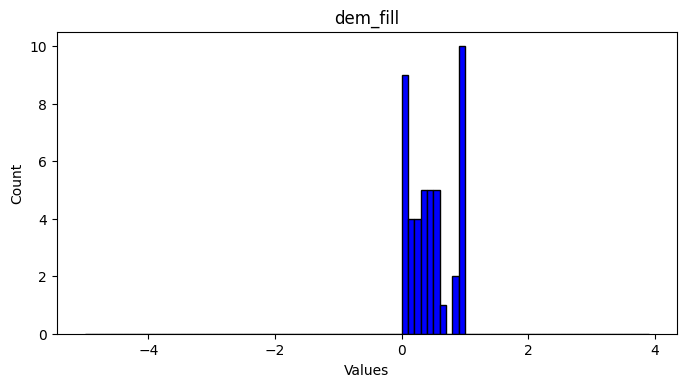

In [272]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
col_name = df.columns.values[dataset_id]
plt.xlabel('Values')
plt.ylabel('Count')
plt.title(col_name)
_ = plt.hist(quantile_df[dataset_id], color = 'blue', edgecolor = 'black', bins = np.arange(-5,4,0.1),label=col_name )

## save normalized dataset

In [18]:
%%time
def maximum_absolute_scaling(df):
    # copy the dataframe
    df_scaled = df.copy()
    # apply maximum absolute scaling
    for column in df_scaled.columns:
        df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    return df_scaled

input_file = '../data/formated_dataset.csv'
print("input_file: ",input_file)
df = pd.read_csv(input_file)
df = maximum_absolute_scaling(df)
df.to_csv("../data/max_abs_df.csv",index=None,header=df.columns.values)
print("output_file: ../data/max_abs_df.csv")

input_file:  ../data/formated_dataset.csv
output_file: ../data/max_abs_df.csv


In [19]:
%%time
input_file = '../data/formated_dataset.csv'
print("input_file: ",input_file)
df = pd.read_csv(input_file)
scaler = preprocessing.QuantileTransformer().fit(df)
quantile_df = scaler.transform(df)
pd.DataFrame(quantile_df).to_csv("../data/quantile_df.csv",index=None,header=df.columns.values)
print("output: quantile_df")


input_file:  ../data/formated_dataset.csv
output: quantile_df


In [20]:
%%time
input_file = '../data/formated_dataset.csv'
print("input_file: ",input_file)
df = pd.read_csv(input_file)
scaler = preprocessing.StandardScaler().fit(df)
scaled_df = scaler.transform(df)
pd.DataFrame(quantile_df).to_csv("../data/scaler_df.csv",index=None,header=df.columns.values)
print("output: scaler_df")


input_file:  ../data/formated_dataset.csv
output: scaler_df


## legacy - cluster_analysis

In [7]:
input_file = '../data/formated_dataset.csv'
print("input_file: ",input_file)
df = pd.read_csv(input_file)
df = df.astype('float32') 
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]




input_file:  ../data/formated_dataset.csv


In [8]:
df.head(10)

,target,tpi_300,Grav_lane_clip,clim_PTA_albers,be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata,be-30y-85m-avg_BLUE+SWIR2,3dem_mag1_fin,ceno_euc_aust1,be-l8-all-85m-avg-BLUE.filled.lzw.nodata,be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata,...,relief_mrvbf_3s_mosaic,Rad2016U_Th,3dem_mag0.fin,s2-dpca-85m_1,s2-dpca-85m_2,s2-dpca-85m_3,water-85m_1,water-85m_2,water-85m_3,saga_wetSM_85_reprojected
0,0.012695,-0.264486,132.345673,803.895752,0.671420,0.2306,0.369132,0.065748,0.0606,0.542396,...,4.0,0.932569,-0.305466,192.0,88.0,63.0,0.026451,-0.039139,-0.062414,10.004804
1,0.004673,0.076412,139.971863,802.700623,0.679385,0.2113,1.456310,0.058309,0.0549,0.529449,...,0.0,0.949415,1.607455,210.0,74.0,47.0,0.017286,-0.018131,-0.033444,9.931655
2,0.005242,0.634743,139.649155,803.203430,0.675992,0.1988,1.622768,0.059387,0.0520,0.518057,...,0.0,0.948752,1.781527,210.0,74.0,46.0,0.012877,-0.002545,-0.014030,10.118466
3,0.004727,0.401459,135.583328,804.416077,0.673164,0.2101,1.423526,0.070222,0.0543,0.541720,...,0.0,0.936961,1.658711,232.0,105.0,67.0,0.021657,-0.044284,-0.063202,10.619378
4,0.016980,0.033232,315.386932,820.631165,0.646681,0.2092,0.368556,0.026916,0.0548,0.537910,...,3.0,1.066115,0.587909,70.0,136.0,79.0,0.078101,-0.029294,-0.108972,11.260143
5,0.011725,-0.052185,315.069031,820.334167,0.649248,0.2041,0.399557,0.028389,0.0496,0.535722,...,0.0,1.027876,0.777037,89.0,120.0,72.0,0.058807,-0.012581,-0.070490,11.104171
6,0.013223,-0.604797,142.260757,797.277527,0.672932,0.2227,-0.708038,0.041636,0.0533,0.536006,...,7.0,0.914205,-1.065460,220.0,108.0,65.0,0.049727,-0.010973,-0.054472,10.428735
7,0.004484,0.588526,141.964584,799.034851,0.674678,0.2281,-0.312755,0.046937,0.0587,0.540961,...,7.0,0.935626,0.298032,229.0,105.0,58.0,0.015205,-0.064529,-0.077979,10.537455
8,0.003591,-0.316811,144.694290,797.207214,0.664256,0.2290,-0.432235,0.072446,0.0568,0.537660,...,5.0,0.947281,-1.118370,125.0,90.0,71.0,0.035860,-0.028991,-0.063413,11.524336
9,0.038092,-0.056219,309.070618,819.942627,0.651325,0.2214,0.470257,0.016383,0.0484,0.556190,...,4.0,1.100984,0.489603,91.0,110.0,49.0,0.041473,-0.001303,-0.042855,10.281479


In [10]:
mvr_stats = df['target']

In [11]:
mvr_stats.values[1::3]

array([0.004673, 0.01698 , 0.004484, ..., 0.010545, 0.025788, 0.027754],
      dtype=float32)

In [12]:
mvr_stats.values[2::3]

array([0.005242, 0.011725, 0.003591, ..., 0.059235, 0.187801, 0.028176],
      dtype=float32)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/547/sg4953/venvs/uncoverml_gadi/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-6febbf65fed4>", line 4, in <module>
    plt.errorbar(df[f].index, df[f] , yerr=df[f].std(), fmt='o', ecolor='g', capthick=2)
  File "/home/547/sg4953/venvs/uncoverml_gadi/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2609, in errorbar
    **({"data": data} if data is not None else {}), **kwargs)
  File "/home/547/sg4953/venvs/uncoverml_gadi/lib/python3.7/site-packages/matplotlib/__init__.py", line 1447, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/home/547/sg4953/venvs/uncoverml_gadi/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 3455, in errorbar
    *apply_mask([x, lower, upper], everymask), **eb_lines_style))
  File "/home/547/sg4953/venvs/uncoverml_gadi/lib/python3.7/site-packages/ma


KeyboardInterrupt



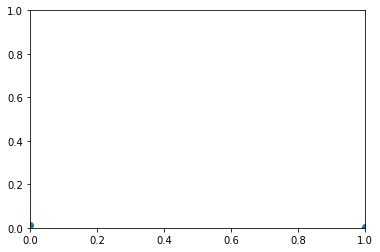

In [28]:
for f in df.columns:
    
    plt.figure()
    plt.errorbar(df[f].index, df[f] , yerr=df[f].std(), fmt='o', ecolor='g', capthick=2)
#     plt.title(splitext(f)[0])
    break

In [ ]:
%matplotlib inline
df.plot()

ERROR! Session/line number was not unique in database. History logging moved to new session 261


<AxesSubplot:>

In [9]:
## legacy - cluster_analysis_national

In [ ]:
# This is a demonstration of a cluster analysis for a national model.
# The K-Means classification was run using 12 classes and 19 covariates.
# These plots (19 for 19 covariates) show the mean and 3*sigma error
# bars for a covariate for each class. 
# The idea behind these plots are to give empirical evidence of the
# range of values of a covariate that goes onto constructing a class.
# These plots will also provide high level understanding of the
# difference between two classes and range of values of the contributiors
# that constitute each class.

In [ ]:


for f in cont.columns:
    cov = df[f]
    cov_mean = cov.values[1::3]
    cov_sd = cov.values[2::3]
    y_err = 1*cov_sd
    plt.figure()
    plt.errorbar(range(1, len(cov_mean) + 1) , cov_mean, yerr=y_err, fmt='o', ecolor='g', capthick=2)
    plt.title(splitext(f)[0])
    plt.xlabel('Class')
    plt.ylabel('Value')
    
    # add labels
    labels = range(1, len(cov_mean) + 1)
    plt.xticks(range(1, len(cov_mean) + 1), labels)